In [1]:
import pandas as pd 
import sys
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from livelossplot import PlotLosses
import time 
sys.path.append('../../duq/')
  
# Importing the Bayesian LR module
import pre
import post
import mc_dropout as MC

Device =  cpu


In [2]:
seed = 1234                  # Assign a value to the seed
pre.set_seed(seed)      # Set the seed for 'random', 'np.random', 'torch.manual_seed' and 'torch.cuda.manual_seed_all'

# Creating Data

In [3]:
def f(x):
    """ Function to plot a damped sinusoid """ 
    A = 2         # Initial amplitude
    lamb = 0.2    # Decay constant
    w = 2         # Angular frequency
    phi = 0       # Phase angle at t=0
    flipped = False # Whether to flip the x axis or not
    if torch.is_tensor(x):
        res = A*torch.exp(-lamb*x)*(torch.cos(w*x+phi) + torch.sin(w*x + phi))
        if flipped:
            res = res.numpy()
            res = np.flip(res).copy()
            res = torch.Tensor(res)
        return res
    else:
        res = A*np.exp(-lamb*x)*(np.cos(w*x+phi) + np.sin(w*x + phi))
        if flipped: res = np.flip(res)
        return res

In [4]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(-10,10,1000)
X2 = np.linspace(-10,10,150)
Y = f(X)
Y2 = f(X2) + np.random.normal(0,0.2,len(X2))

df = pd.DataFrame({"X":X,"Y":Y})
df2 = pd.DataFrame({"X":X2,"Y":Y2})

x_cols=[0]
y_cols=[1]
component = 0 # Sort by the x component 
cutoff_percentile = (0.45,0.55)
val_split = 0.4
component_name = "Y"

df, data_mean, data_std = pre.process_df_euclid(df=df, x_cols=x_cols)
df2, data_mean2, data_std2 = pre.process_df_euclid(df=df2, x_cols=x_cols)

y_mean = data_mean[y_cols].values
x_mean = data_mean[x_cols].values
y_std = data_std[y_cols].values
x_std = data_std[x_cols].values

TRAIN, VAL, TEST = pre.split_data(df2, component=component, y_cols=y_cols, x_cols=x_cols, cutoff_percentile=cutoff_percentile, val_split=val_split, seed=seed)
x_train, y_train, train_data, train_indices = TRAIN
x_val, y_val, val_data, val_indices = VAL
x_test, y_test, test_data, test_indices = TEST

## Import, Pre-process and Split Data

# Neural Network Instantiation and Training

## Define Parameters of the Model

In [9]:
# Define the wandb parameters
parameters = dict(
    # Specific to this method
    drop_prob= 0.2,              # Probablity that a neuron will be switched off
    num_samples=150,              # How many forward passes of the network to make to construct the posterior distribution
    
    # Generic Hyperparameters
    num_epochs= 2000,
    batch_size= len(x_train), # Batch size for training data
    lr=  5e-4,                   # Learning rate
    weight_decay= 0.01,          # Weight decay. 'None' to disable L2 regularisation
    
    # Model architecture
    input_dim= len(x_cols),                # Number of input neurons
    output_dim= len(y_cols),               # Number of output neurons
    num_units= 300,              # Number of neurons per hidden layer
    num_layers=3,
    
    # Logging only
    y_cols = y_cols,             # Which column(s) contain the dependent variable(s) / label(s) 
    x_cols = x_cols,             # Which column(s) contain the independent variable(s) / feature(s)
    component = component,       # Which parameter are we sorting by (as an int)? 
    sortby=component_name,       # Name of the component we're sorting by (as a string)
    model_name= "MC_Dropout_1D",    # For logging only
    criterion_name= "MSELoss",   # For logging only
    optimiser_name= "Adam",      # For logging only
    cutoff_percentile = cutoff_percentile,  # How much we're splitting from top and bottom of sorted training set for test set 
    val_split=val_split,         # How much we're splitting from the train set (minus the test set), as a float between 0-1
    seed=seed                   # Random seed used (for logging only)
)

assert parameters['output_dim'] == len(y_cols), f"Please ensure that the number of output neurons is correct! There should be {len(y_cols)}"
assert parameters['input_dim'] == len(x_cols), f"Please ensure that the number of input neurons is correct! There should be {len(x_cols)}" 

## If using Weights and Biases API, Log In

In [10]:
# Whether or not to log the run to Weights and Biases (https://wandb.ai/home). Requires an account
wandb_mode = False

if wandb_mode: 
    import wandb
    wandb.login()
    wandb.init(config=parameters, entity="archieluxton", project=parameters['model_name'])

## Instantiate the Model Class

In [11]:
# Instantiate a model class of type MC Dropout
model = MC.MC_Dropout(train_data = train_data,
                      parameters=parameters, 
                      val_data=val_data,
                      data_mean=data_mean,
                      data_std=data_std,
                      wandb_mode=wandb_mode)

## Train the Model

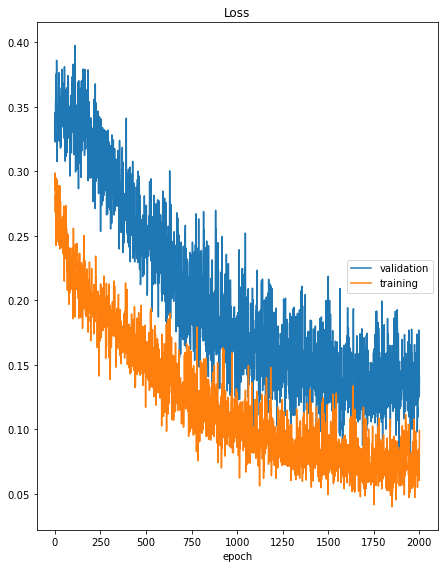

Loss
	validation       	 (min:    0.066, max:    0.398, cur:    0.140)
	training         	 (min:    0.040, max:    0.299, cur:    0.099)
Time elapsed: 5.70s.
Number of trainable model parameters: 91201, number of training samples: 22
Used batches of 22.

Time taken: 5.713793516159058s


In [12]:
import time

checkpoint_path = "../../trained_models/for_retraining/MC_Dropout_1D"

start = time.time()
%matplotlib inline

net = model.train_model(checkpoint=True, checkpoint_path=checkpoint_path)

end = time.time()
print(f"Time taken: {end-start}s")

# Perform Forward Passes for each Dataset

In [13]:
# Run samples for the full domain, allows plotting of the uncertainty etc
samples_full, means_full, stds_full, y_train_np_full = model.run_sampling(torch.Tensor(df["X"]), torch.Tensor(df["Y"]))

# Sort values for plotting 
means_full_, stds_full_, x_full_ = post.sort_data([means_full.squeeze(), stds_full.squeeze(), df["X"]], sortby=2)

***
***
# Post-Processing and Visualisation

## Plot the Uncertainty of Each Datapoint (Train, Test and Val)
### Error Bar Plot

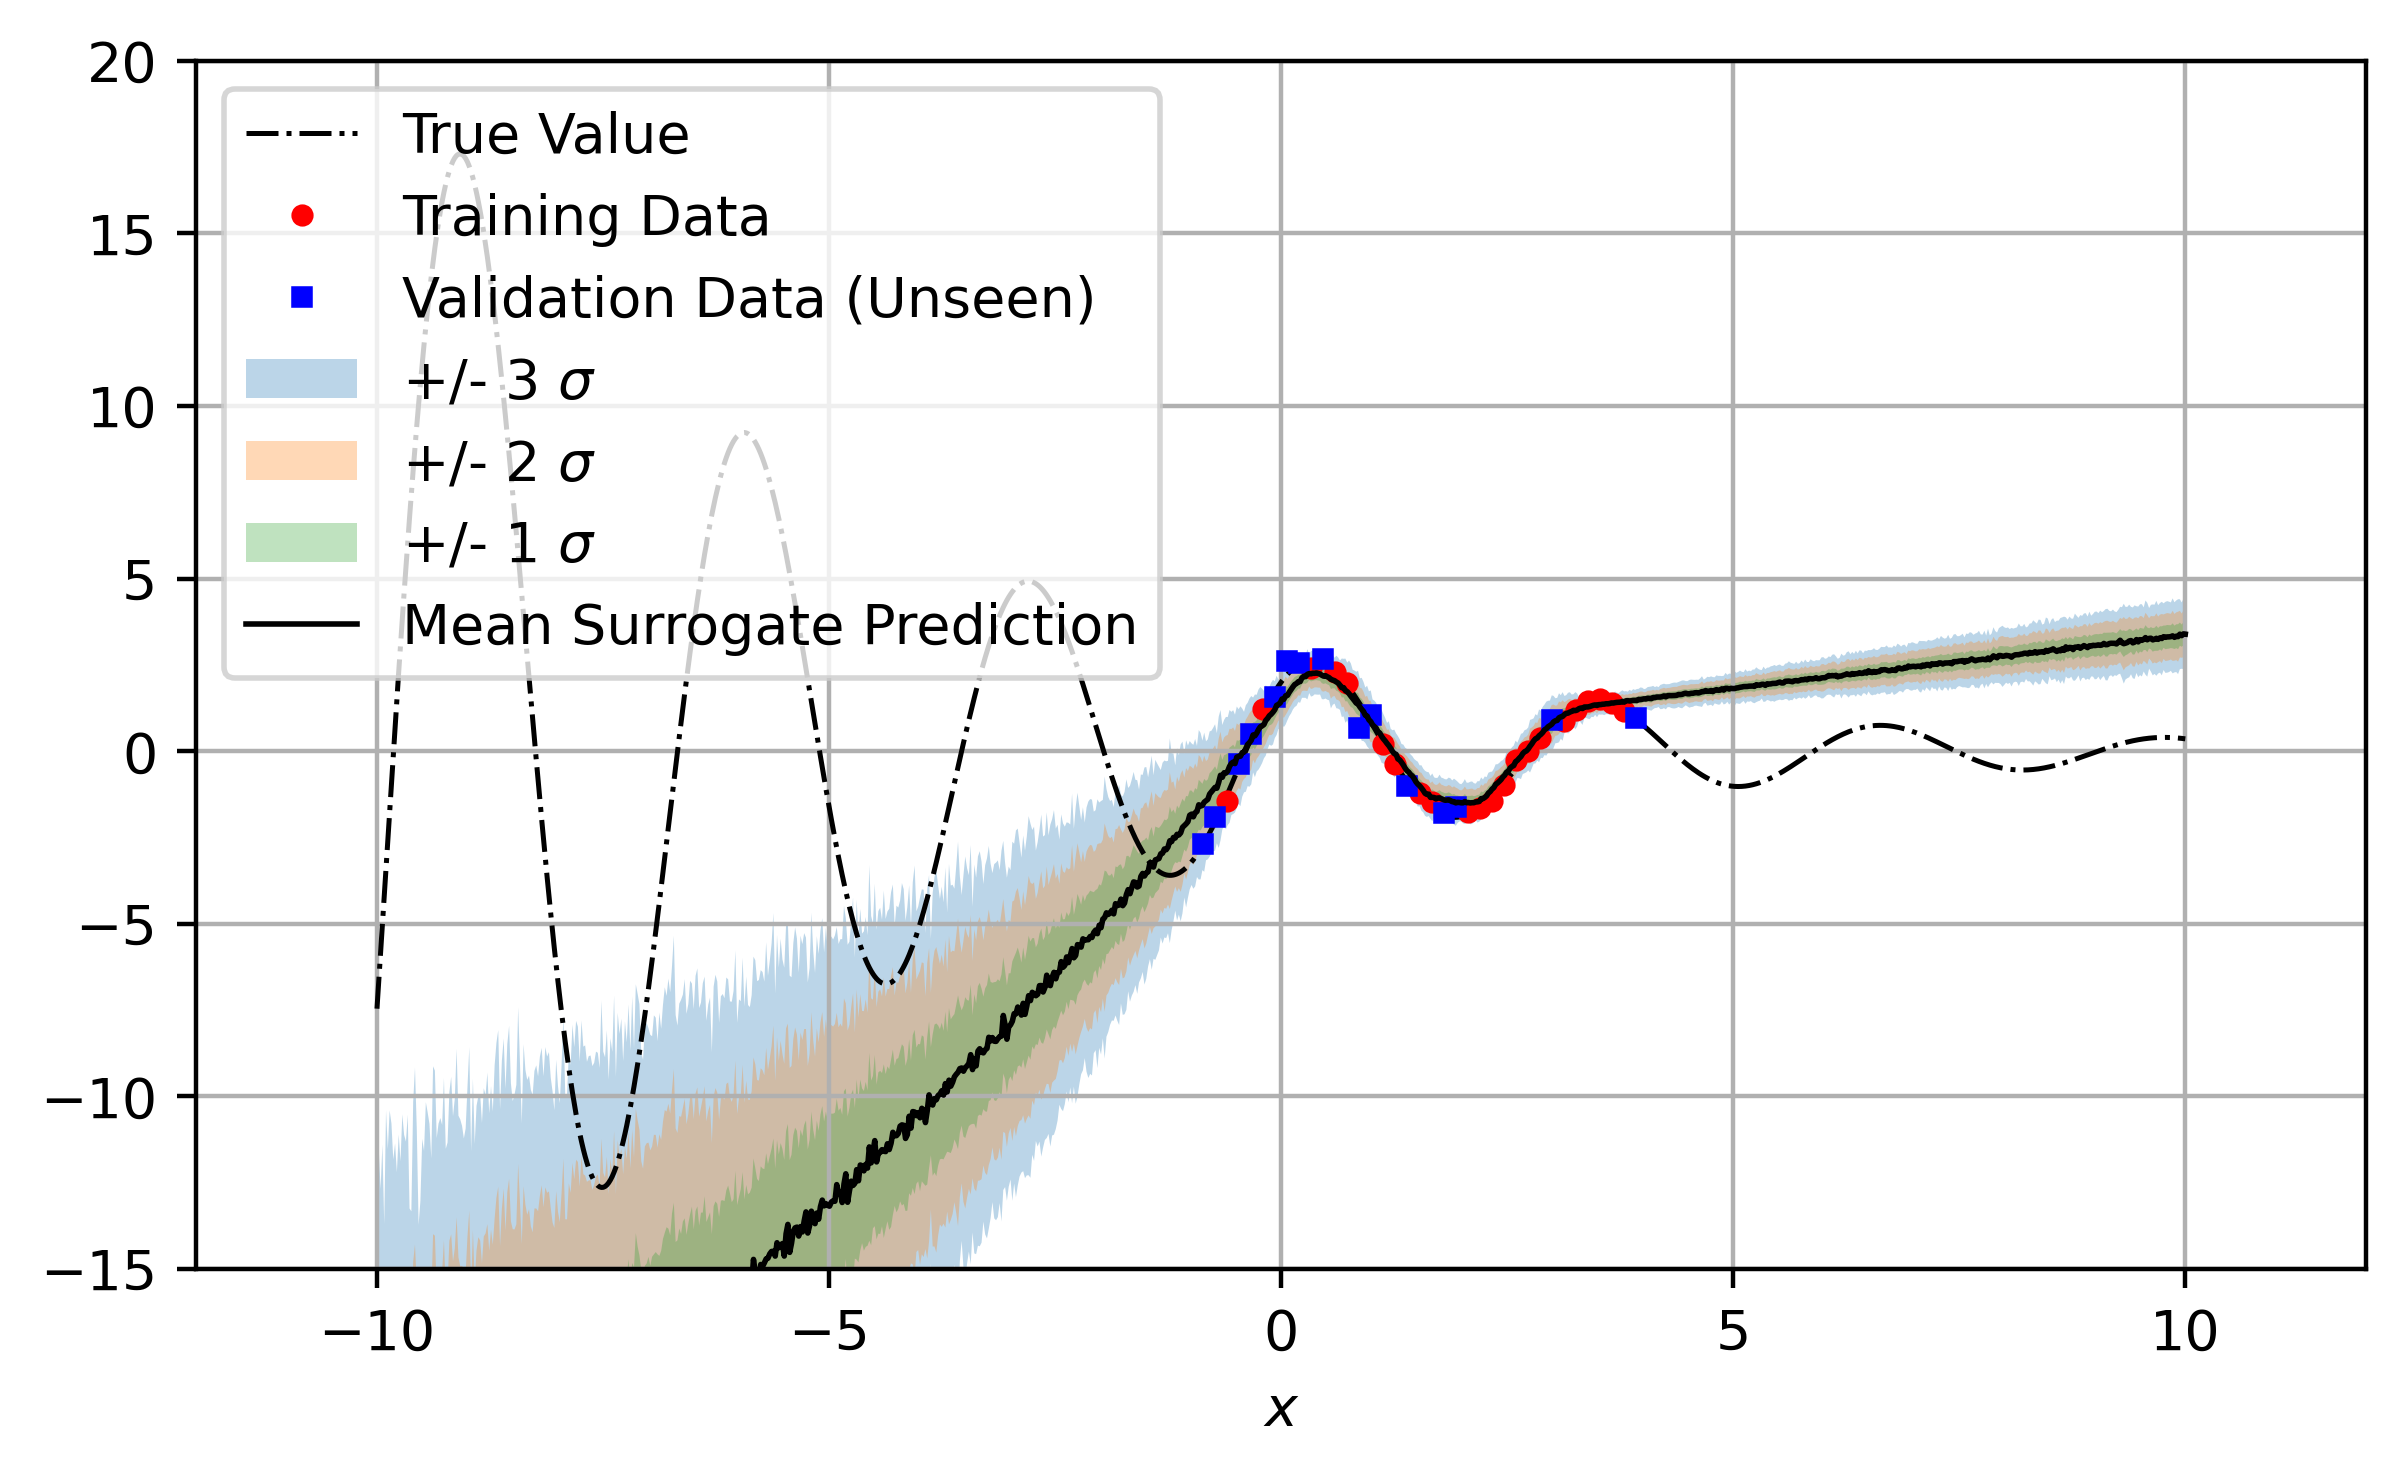

In [32]:
## PLOT
plt.figure(figsize=(7,4), dpi=400)

plt.plot(X, Y, 'k-.',linewidth=0.9,label="True Value")

plt.plot(pre.unnormalise(x_train,x_mean,x_std),
         pre.unnormalise(y_train,y_mean,y_std),
         'or',
         #alpha = 0.5,
         markersize=3,
         label="Training Data")

plt.plot(pre.unnormalise(x_val,x_mean,x_std),
         pre.unnormalise(y_val,y_mean,y_std),
         'sb',
         #alpha=0.5,
         markersize=3,
         label="Validation Data (Unseen)")

plt.fill_between(X, means_full_.ravel() + 3*stds_full_.flatten(), means_full_.ravel() - 3*stds_full_.flatten(), alpha = 0.3, label = '+/- 3 $\sigma$')
plt.fill_between(X, means_full_.ravel() + 2*stds_full_.flatten(), means_full_.ravel() - 2*stds_full_.flatten(), alpha = 0.3, label = '+/- 2 $\sigma$')
plt.fill_between(X, means_full_.ravel() + 1*stds_full_.flatten(), means_full_.ravel() - 1*stds_full_.flatten(), alpha = 0.3, label = '+/- 1 $\sigma$')
plt.plot(X, means_full_.squeeze(), color = 'black', linewidth = 1, label="Mean Surrogate Prediction")

plt.ylim((-15,20))
plt.xlim((-12,12))
plt.grid()
plt.legend(loc="upper left")
plt.xlabel('$x$')
#plt.title('Physical Process or Simulation')
plt.show()

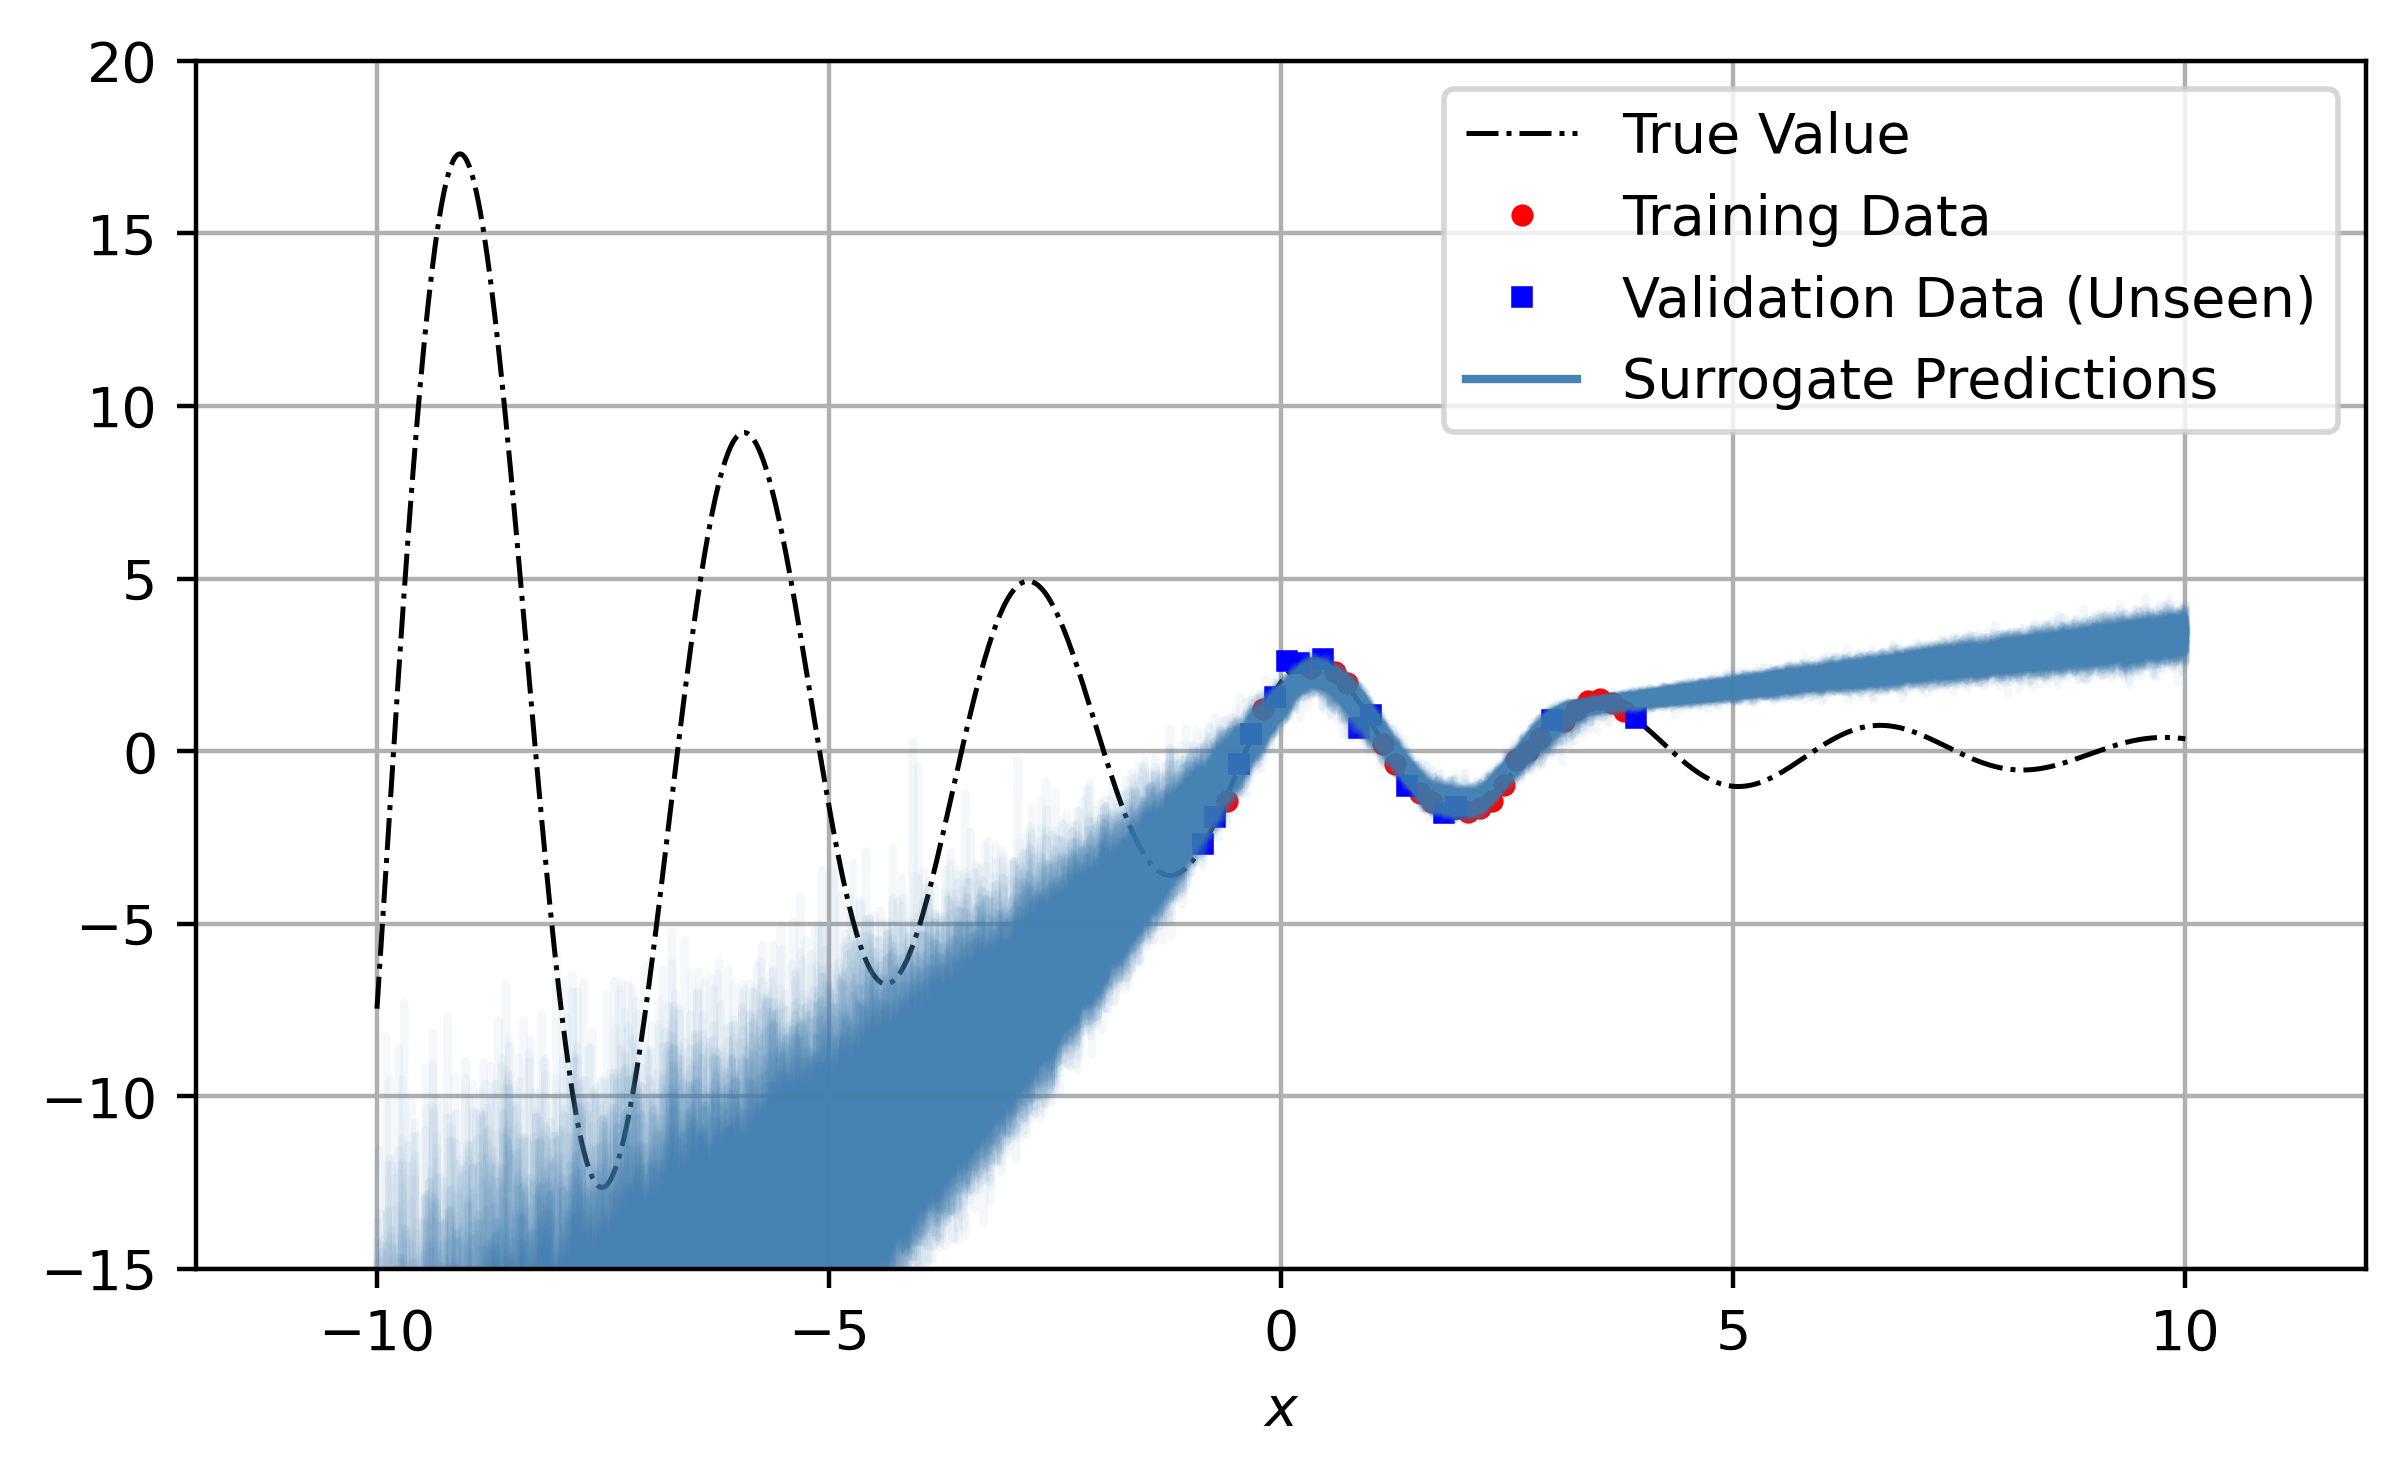

In [34]:
## PLOT
plt.figure(figsize=(7,4), dpi=400)

plt.plot(X, Y, 'k-.',linewidth=0.9,label="True Value")

plt.plot(pre.unnormalise(x_train,x_mean,x_std),
         pre.unnormalise(y_train,y_mean,y_std),
         'or',
         #alpha = 0.5,
         markersize=3,
         label="Training Data")

plt.plot(pre.unnormalise(x_val,x_mean,x_std),
         pre.unnormalise(y_val,y_mean,y_std),
         'sb',
         #alpha=0.5,
         markersize=3,
         label="Validation Data (Unseen)")

plt.plot(X, samples_full[:].T,'steelblue',alpha=0.05)

plt.plot(0,0,'steelblue',label="Surrogate Predictions")

plt.ylim((-15,20))
plt.xlim((-12,12))
plt.grid()
plt.legend()
plt.xlabel('$x$')
#plt.title('Physical Process or Simulation')
plt.show()


# Adding some OOD data to see what hapepens

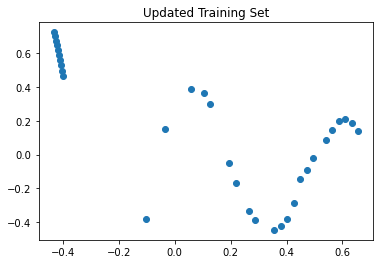

In [16]:
num_additional = 10
x_ood = np.linspace(-2.5,-2.3,num_additional)
y_ood = f(x_ood)

x_ood_norm = torch.Tensor(pre.normalise(x_ood, x_mean, x_std)).unsqueeze(1)
y_ood_norm = torch.Tensor(pre.normalise(y_ood, y_mean, y_std)).unsqueeze(1)


x_train_new = torch.concat((x_train, x_ood_norm))
y_train_new = torch.concat((y_train, y_ood_norm))
ind = [i for i in range(len(train_indices),len(train_indices)+num_additional)]
train_indices_new = np.concatenate((train_indices, ind))

train_data_new = TensorDataset(x_train_new, y_train_new)

plt.plot(x_train_new, y_train_new, 'o')
plt.title("Updated Training Set");

In [17]:
# Instantiate a model class of type MC Dropout
model_new = MC.MC_Dropout(train_data = train_data_new,
                      parameters=parameters, 
                      val_data=val_data,
                      data_mean=data_mean,
                      data_std=data_std,
                      wandb_mode=wandb_mode)

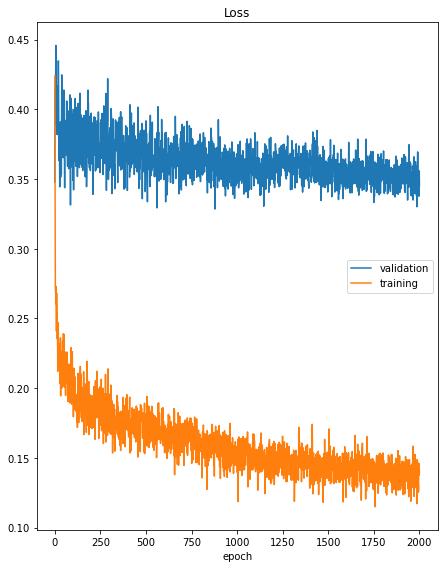

Loss
	validation       	 (min:    0.328, max:    0.446, cur:    0.345)
	training         	 (min:    0.115, max:    0.424, cur:    0.140)
Time elapsed: 11.00s.
Number of trainable model parameters: 91201, number of training samples: 32
Used batches of 22.

Time taken: 11.005009174346924s


In [18]:
start = time.time()
%matplotlib inline
net_new = model_new.train_model()
end = time.time()
print(f"Time taken: {end-start}s")

In [19]:
# Run samples for the full domain, allows plotting of the uncertainty etc
samples_full_new, means_full_new, stds_full_new, y_train_np_full_new = model_new.run_sampling(torch.Tensor(df["X"]), torch.Tensor(df["Y"]))

# Sort values for plotting 
means_full_new_, stds_full_new_, x_full_new_ = post.sort_data([means_full_new.squeeze(), stds_full_new.squeeze(), df["X"]], sortby=2)

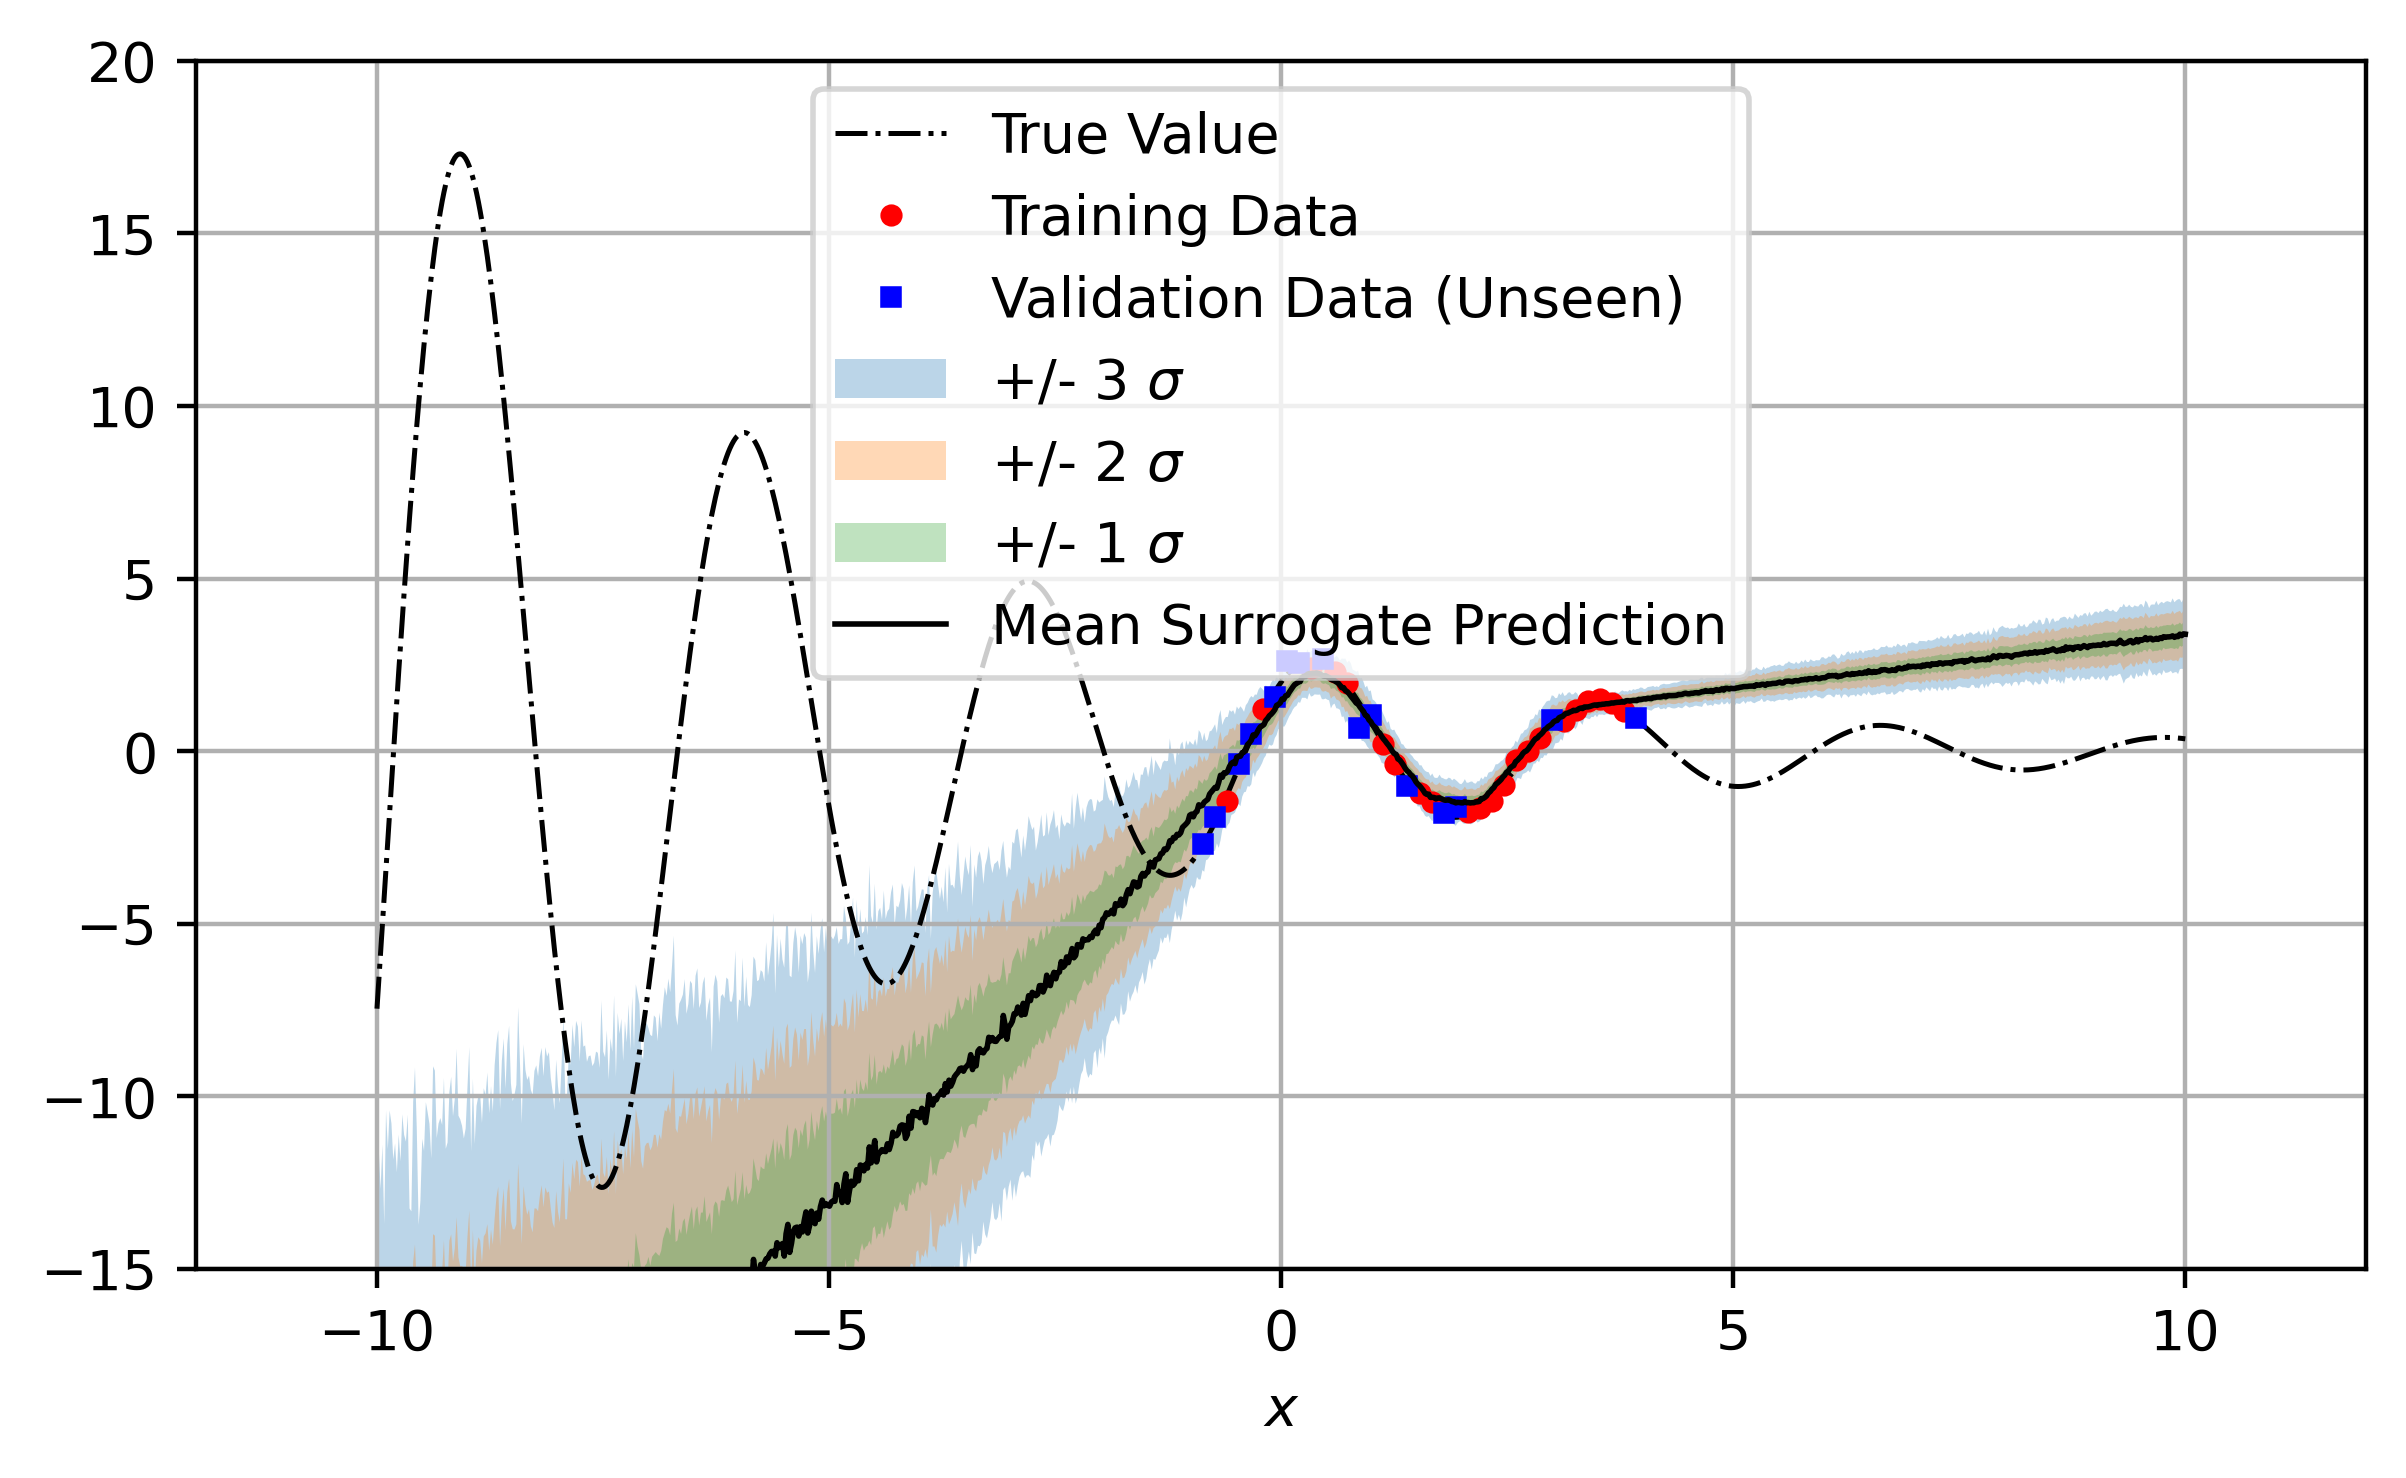

In [20]:
## PLOT
plt.figure(figsize=(7,4), dpi=400)

plt.plot(X, Y, 'k-.',linewidth=0.9,label="True Value")

plt.plot(pre.unnormalise(x_train,x_mean,x_std),
         pre.unnormalise(y_train,y_mean,y_std),
         'or',
         #alpha = 0.5,
         markersize=3,
         label="Training Data")

plt.plot(pre.unnormalise(x_val,x_mean,x_std),
         pre.unnormalise(y_val,y_mean,y_std),
         'sb',
         #alpha=0.5,
         markersize=3,
         label="Validation Data (Unseen)")

plt.fill_between(X, means_full_.ravel() + 3*stds_full_.flatten(), means_full_.ravel() - 3*stds_full_.flatten(), alpha = 0.3, label = '+/- 3 $\sigma$')
plt.fill_between(X, means_full_.ravel() + 2*stds_full_.flatten(), means_full_.ravel() - 2*stds_full_.flatten(), alpha = 0.3, label = '+/- 2 $\sigma$')
plt.fill_between(X, means_full_.ravel() + 1*stds_full_.flatten(), means_full_.ravel() - 1*stds_full_.flatten(), alpha = 0.3, label = '+/- 1 $\sigma$')
plt.plot(X, means_full_.squeeze(), color = 'black', linewidth = 1, label="Mean Surrogate Prediction")

plt.ylim((-15,20))
plt.xlim((-12,12))
plt.grid()
plt.legend()
plt.xlabel('$x$')
#plt.title('Physical Process or Simulation')
plt.show()

# Retraining Model with OOD data - adding points only

In [21]:
train_data_new2 = TensorDataset(x_ood_norm, y_ood_norm)

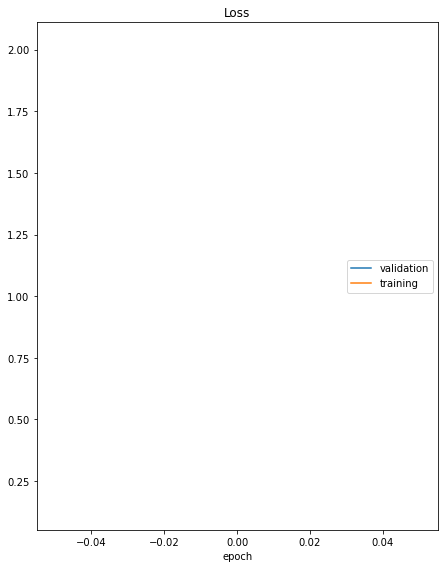

Loss
	validation       	 (min:    0.146, max:    0.146, cur:    0.146)
	training         	 (min:    2.017, max:    2.017, cur:    2.017)
Time elapsed: 0.34s.
Number of trainable model parameters: 91201, number of training samples: 10
Used batches of 10.

Ran epoch 2000 to 2050


In [22]:
checkpoint = torch.load(checkpoint_path)
model.net.load_state_dict(checkpoint['model'])
model.optimiser.load_state_dict(checkpoint['optimiser'])

start_epoch_new = checkpoint['epoch']
epochs_new = 50 
batch_size_new = len(train_data_new2)

net2, train_loss, val_loss = model.retrain_model(train_data_new2,
                                                batch_size_new,
                                                epochs_new)

print(f"Ran epoch {start_epoch_new} to {start_epoch_new + epochs_new}")

In [23]:
# Run samples for the full domain, allows plotting of the uncertainty etc
samples_full_new2, means_full_new2, stds_full_new2, y_train_np_full_new2 = model.run_sampling(torch.Tensor(df["X"]), torch.Tensor(df["Y"]))

# Sort values for plotting 
means_full_new2_, stds_full_new2_, x_full_new2_ = post.sort_data([means_full_new2.squeeze(), stds_full_new2.squeeze(), df["X"]], sortby=2)

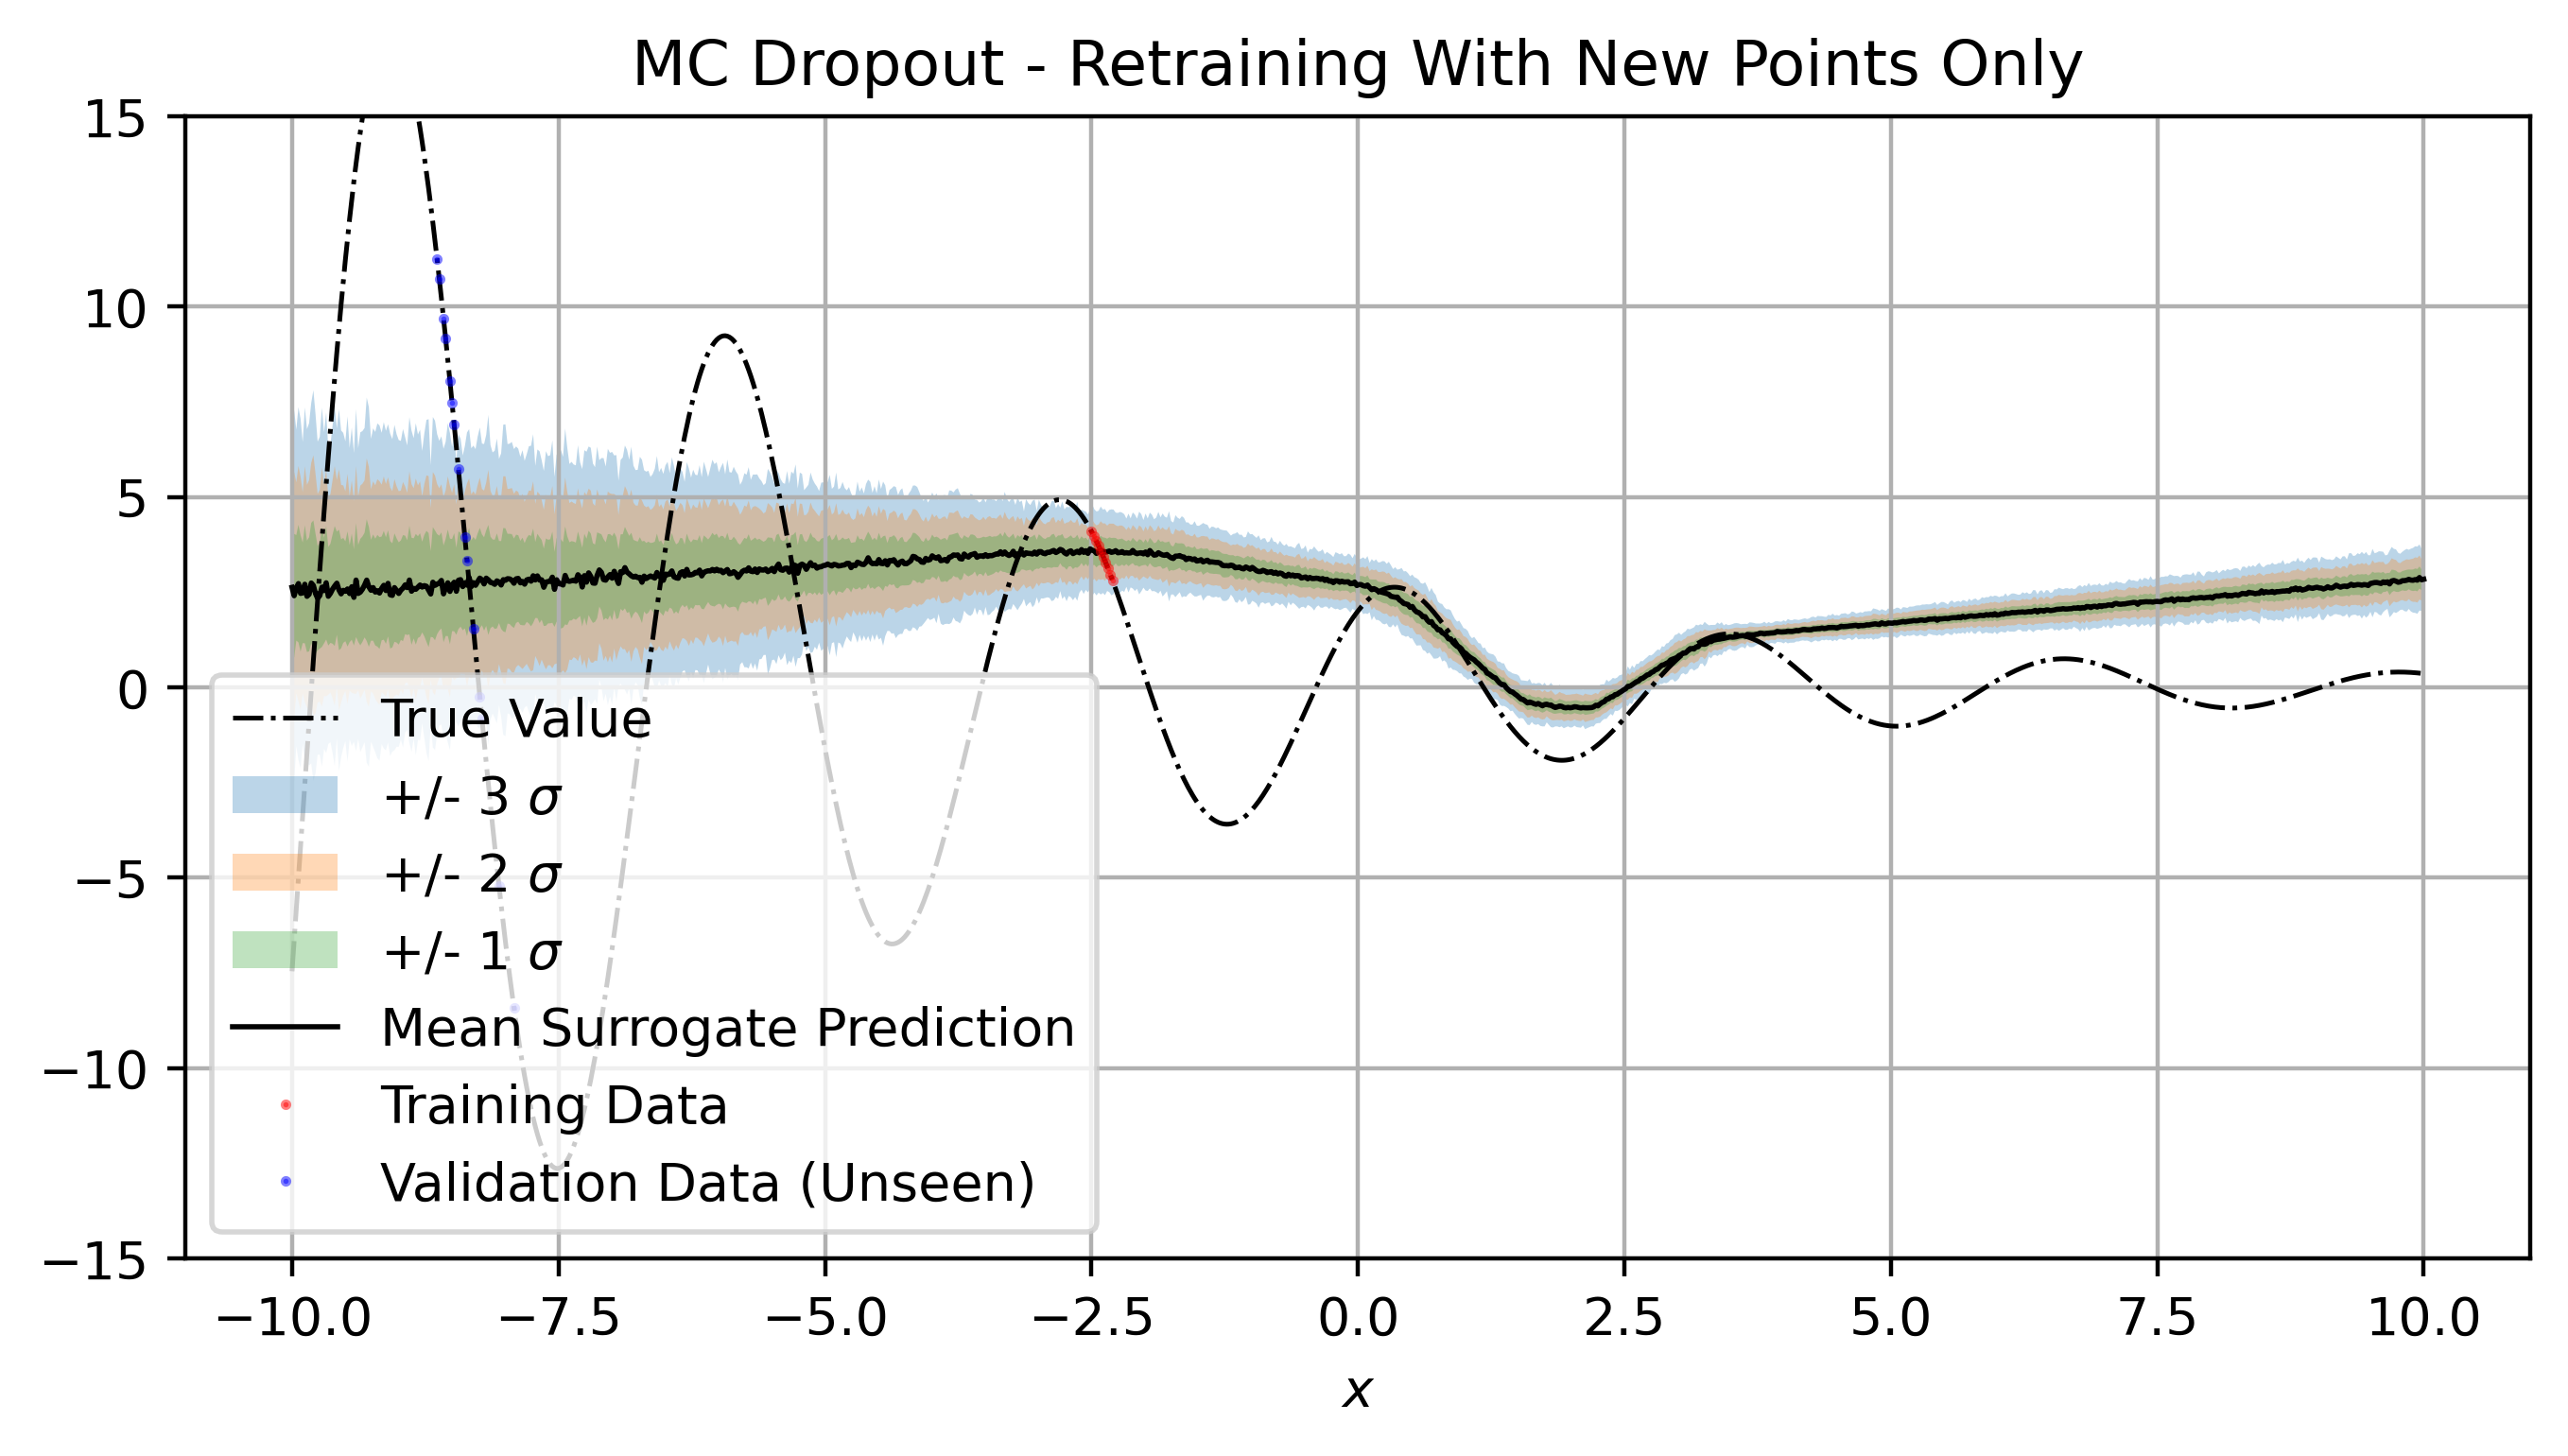

In [24]:

plt.figure(figsize=(8,4), dpi=400)

plt.plot(X, Y, 'k-.',linewidth=0.9,label="True Value")
plt.fill_between(X, means_full_new2_.ravel() + 3*stds_full_new2_.flatten(), means_full_new2_.ravel() - 3*stds_full_new2_.flatten(), alpha = 0.3, label = '+/- 3 $\sigma$')
plt.fill_between(X, means_full_new2_.ravel() + 2*stds_full_new2_.flatten(), means_full_new2_.ravel() - 2*stds_full_new2_.flatten(), alpha = 0.3, label = '+/- 2 $\sigma$')
plt.fill_between(X, means_full_new2_.ravel() + 1*stds_full_new2_.flatten(), means_full_new2_.ravel() - 1*stds_full_new2_.flatten(), alpha = 0.3, label = '+/- 1 $\sigma$')
plt.plot(X, means_full_new2_.squeeze(), color = 'black', linewidth = 1, label="Mean Surrogate Prediction")

plt.plot(x_ood, y_ood, 'or', alpha = 0.5, markersize=1, label="Training Data")
plt.plot(X[val_indices], Y[val_indices], 'ob', alpha=0.5, markersize=1, label="Validation Data (Unseen)")
#plt.plot(X[test_indices], Y[test_indices], 'oy', alpha=0.5, markersize=3, label="Test Data (Unseen)")
plt.ylim((-15,15))
plt.grid()
plt.legend()
plt.xlabel('$x$')
plt.title('MC Dropout - Retraining With New Points Only')
plt.show()

# Retraining Using Whole Extended Set

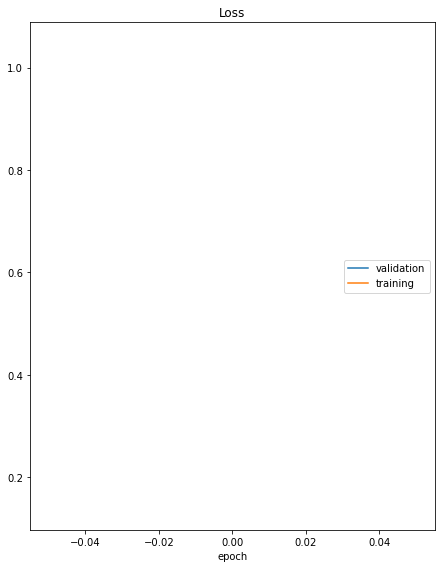

Loss
	validation       	 (min:    0.142, max:    0.142, cur:    0.142)
	training         	 (min:    1.043, max:    1.043, cur:    1.043)
Time elapsed: 0.49s.
Number of trainable model parameters: 91201, number of training samples: 32
Used batches of 32.

Ran epoch 2000 to 2050


In [25]:
checkpoint = torch.load(checkpoint_path)
model.net.load_state_dict(checkpoint['model'])
model.optimiser.load_state_dict(checkpoint['optimiser'])

start_epoch_new = checkpoint['epoch']

epochs_new = 50 
model.parameters["burnin_epochs"] = 0

batch_size_new = len(train_data_new)

net2, train_loss, val_loss = model.retrain_model(train_data_new,
                                                batch_size_new,
                                                epochs_new)

print(f"Ran epoch {start_epoch_new} to {start_epoch_new + epochs_new}")

In [26]:
# Run samples for the full domain, allows plotting of the uncertainty etc
samples_full_new3, means_full_new3, stds_full_new3, y_train_np_full_new3 = model.run_sampling(torch.Tensor(df["X"]), torch.Tensor(df["Y"]))

# Sort values for plotting 
means_full_new3_, stds_full_new3_, x_full_new3_ = post.sort_data([means_full_new3.squeeze(), stds_full_new3.squeeze(), df["X"]], sortby=2)

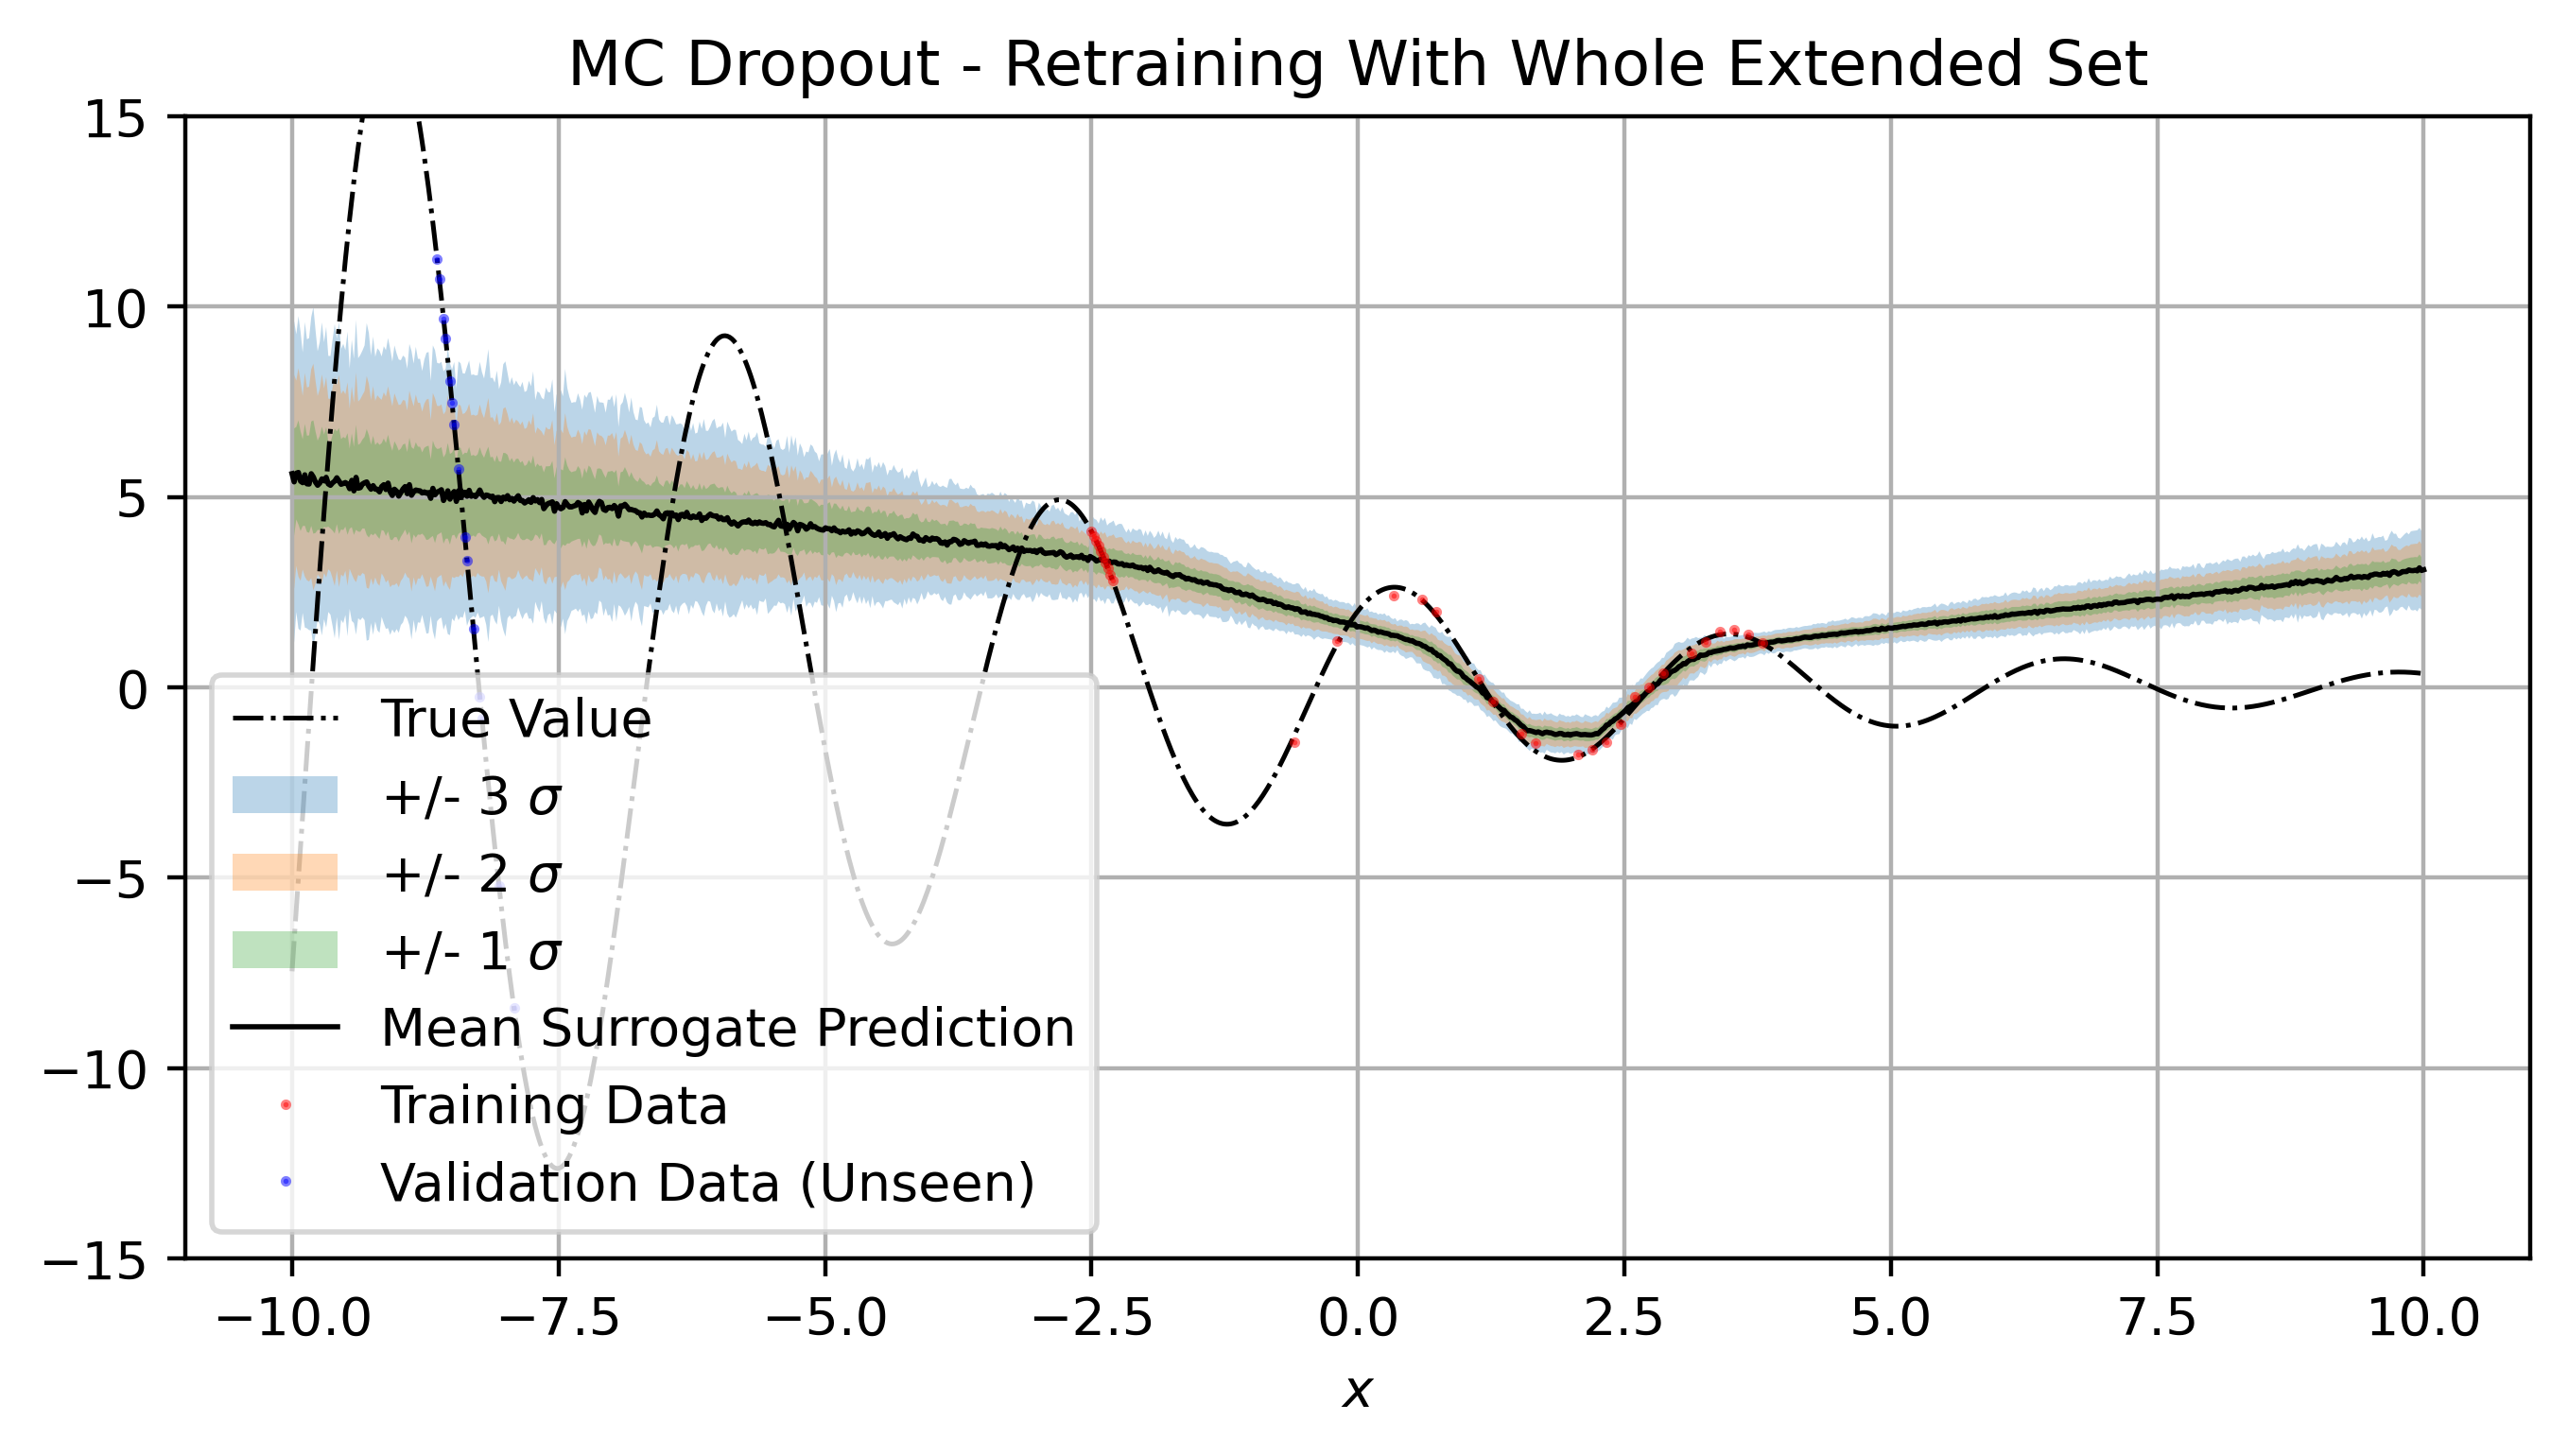

In [27]:

plt.figure(figsize=(8,4), dpi=400)

plt.plot(X, Y, 'k-.',linewidth=0.9,label="True Value")
plt.fill_between(X, means_full_new3_.ravel() + 3*stds_full_new3_.flatten(), means_full_new3_.ravel() - 3*stds_full_new3_.flatten(), alpha = 0.3, label = '+/- 3 $\sigma$')
plt.fill_between(X, means_full_new3_.ravel() + 2*stds_full_new3_.flatten(), means_full_new3_.ravel() - 2*stds_full_new3_.flatten(), alpha = 0.3, label = '+/- 2 $\sigma$')
plt.fill_between(X, means_full_new3_.ravel() + 1*stds_full_new3_.flatten(), means_full_new3_.ravel() - 1*stds_full_new3_.flatten(), alpha = 0.3, label = '+/- 1 $\sigma$')
plt.plot(X, means_full_new3_.squeeze(), color = 'black', linewidth = 1, label="Mean Surrogate Prediction")

x_train_unnormalised = pre.unnormalise(x_train_new, x_mean, x_std)
y_train_unnormalised = pre.unnormalise(y_train_new, y_mean, y_std)

plt.plot(x_train_unnormalised, y_train_unnormalised, 'or', alpha = 0.5, markersize=1, label="Training Data")
plt.plot(X[val_indices], Y[val_indices], 'ob', alpha=0.5, markersize=1, label="Validation Data (Unseen)")
#plt.plot(X[test_indices], Y[test_indices], 'oy', alpha=0.5, markersize=3, label="Test Data (Unseen)")
plt.ylim((-15,15))
plt.grid()
plt.legend()
plt.xlabel('$x$')
plt.title('MC Dropout - Retraining With Whole Extended Set')
plt.show()